# Chainer チュートリアル その３

https://qiita.com/mitmul/items/eccf4e0a84cb784ba84a
のなかから、Chainarで自分のネットワークを定義してみる。


## CIFAR10 データセット
MNISTを卒業し、今回はCIFAR10データセットを使う。CIFAR10は$32\times 32$のカラー画像が10クラスに分類されている。これを使ってモデルの作成と評価、及び試行錯誤をしてみよう。

まず、データセットを読み込む。

In [26]:
from chainer.datasets import cifar

train, test = cifar.get_cifar10()

訓練データの一部を表示してみよう。

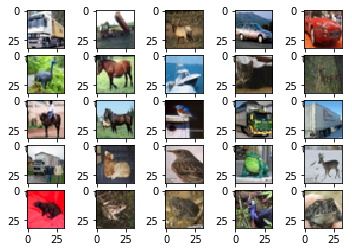

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(1,26):
    img,label = train[i]
    plt.subplot(5, 5, i)
    plt.imshow(img.transpose(1, 2, 0))

MNISTに比べて、ずいぶんと賑やかな画像である。

# モデルの定義

これらの画像のクラス分類を行うため、
3つの畳み込み層と、2つの全結合層を持つネットワークを作成していこう。
モデルを定義するときは、

1. コンストラクタでパラメータを持つレイヤをインスタンス化
1. `__call__`でforward計算を定義

するのであった。

 Convolution2D(in_channels, out_channels, k_size, stide='', pad='')

in/out _channelsは、入力と出力のチャネル数を意味する。k_sizeは、k_size x k_sizeのフィルタを適用することを意味する。strideはフィルタをスキャンするときに動かす量、padは外周にパディングする量である。

In [28]:
import chainer
import chainer.functions as F
import chainer.links as L

class MyModel(chainer.Chain):

    def __init__(self, n_out):
        super(MyModel, self).__init__(
            conv1=L.Convolution2D(None, 32, 3, 3, 1),
            conv2=L.Convolution2D(32, 64, 3, 3, 1),
            conv3=L.Convolution2D(64, 128, 3, 3, 1),
            fc4=L.Linear(None, 1000),
            fc5=L.Linear(1000, n_out)
        )

    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.fc4(h))
        h = self.fc5(h)
        return h

## 2.学習

モデルを後で入れ替えられるような、汎用的な訓練用の関数を定義する。
この関数は以下の要素を指定できる。

- モデルのオブジェクト
- バッチサイズ
- 使用するGPU ID
- 学習を終了するエポック数
- データセットオブジェクト

これらのパラメータを受け取ると、与えられたデータで訓練を行い、
学習後のモデルを返す。


In [29]:
from chainer.datasets import cifar
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions

def train(model_object, batchsize=64, gpu_id=0, max_epoch=20, train_dataset=None, test_dataset=None):

    # 1. Dataset
    if train_dataset is None and test_dataset is None:
        train, test = cifar.get_cifar10()
    else:
        train, test = train_dataset, test_dataset

    # 2. Iterator
    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    # 3. Model
    model = L.Classifier(model_object)
    if gpu_id >= 0:
        model.to_gpu(gpu_id)

    # 4. Optimizer
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    # 5. Updater
    updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

    # 6. Trainer
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='{}_cifar10_result'.format(model_object.__class__.__name__))

    # 7. Evaluator

    class TestModeEvaluator(extensions.Evaluator):

        def evaluate(self):
            model = self.get_target('main')
            model.train = False
            ret = super(TestModeEvaluator, self).evaluate()
            model.train = True
            return ret

    trainer.extend(extensions.LogReport())
    trainer.extend(TestModeEvaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.run()
    del trainer

    return model

model = train(MyModel(10), gpu_id=0)  # CPUで実行する場合は、`gpu_id=-1`を指定して下さい。

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.56365     0.430986       1.35279               0.505673                  7.11568       
2           1.24726     0.551116       1.21664               0.555036                  14.2277       
3           1.09389     0.608155       1.15713               0.58121                   21.4169       
4           0.971907    0.651789       1.09966               0.60828                   28.437        
5           0.868827    0.689238       1.06397               0.626891                  35.6529       
6           0.760442    0.728413       1.08639               0.622711                  43.3208       
7           0.656849    0.764405       1.10312               0.629678                  50.7752       
8           0.554894    0.803177       1.17615               0.631768                  57.9951       
9           0.448442    0.841852       1.26152               0.632265               

20エポック終了後の損失と精度のグラフを見てみよう。

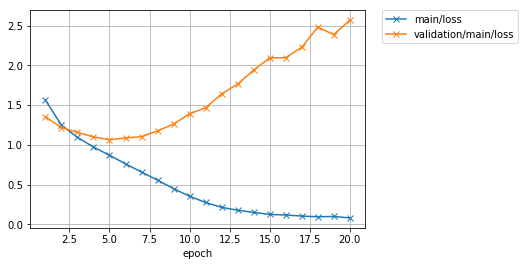

In [30]:
from IPython.display import Image
Image(filename='MyModel_cifar10_result/loss.png')

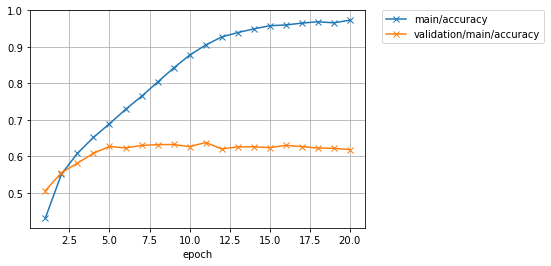

In [31]:
Image(filename='MyModel_cifar10_result/accuracy.png')

学習データの精度が`main/accuracy`で、テストデータでの精度が`validation/main/accuracy`でプロットされている。
学習データでの精度は97%近くと良いが、テストデータでの精度が62%近くと良くない。
これは学習データにオーバーフィッティングしているせいだろう。

## 3. 学習済みモデルを使った予測


試しに、いくつかのテスト画像を分類させてみよう。


predicted_label: cat
answer: dog


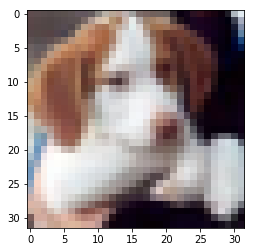

predicted_label: horse
answer: horse


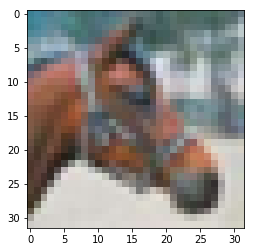

predicted_label: ship
answer: ship


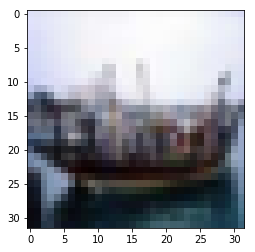

predicted_label: frog
answer: frog


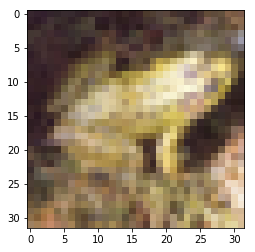

predicted_label: horse
answer: horse


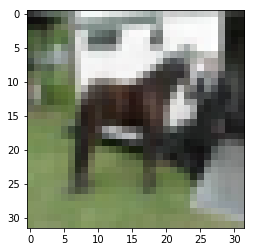

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

cls_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
             'dog', 'frog', 'horse', 'ship', 'truck']

def predict(model, image_id):
    _, test = cifar.get_cifar10()
    x, t = test[image_id]
    model.to_cpu()
    y = model.predictor(x[None, ...]).data.argmax(axis=1)[0]
    print('predicted_label:', cls_names[y])
    print('answer:', cls_names[t])

    plt.imshow(x.transpose(1, 2, 0))
    plt.show()

for i in range(16, 21):
    predict(model, i)

最後のhorseががautomobileに分類されてしまっている。もう少し汎化性能の高いモデルを作ってみよう。

## 4. 深いモデルを定義する

畳み込み層と全結合層が交互に現れる、たくさんの層を持つモデルを定義する。
1層の畳み込みネットワークを`ConvBlock`、1層の全結合ネットワークを`LinearBlock`として定義し
これを積み重ねるようにしてみよう。まずはこれらを定義する。

In [37]:
class ConvBlock(chainer.Chain):
    def __init__(self, n_ch, pool_drop=False):
        w = chainer.initializers.HeNormal()
        super(ConvBlock, self).__init__(
            conv=L.Convolution2D(None, n_ch, 3, 1, 1,
                                 nobias=True, initialW=w),
            bn=L.BatchNormalization(n_ch)
        )

        self.train = True
        self.pool_drop = pool_drop

    def __call__(self, x):
        h = F.relu(self.bn(self.conv(x)))
        if self.pool_drop:
            h = F.max_pooling_2d(h, 2, 2)
            h = F.dropout(h, ratio=0.25)
        return h

class LinearBlock(chainer.Chain):

    def __init__(self):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__(
            fc=L.Linear(None, 1024, initialW=w))
        self.train = True

    def __call__(self, x):
        return F.dropout(F.relu(self.fc(x)), ratio=0.5)

`ConvBlock`は畳み込み層とBatch nomalization層を持つネットワークである。`HeNormal()`は重みを標準偏差$\sqrt{2/N}$の正規分布に従う乱数で初期化する関数で、Kaming Heらによって提唱された方法だ。
`BatchNormalization`はミニバッチ毎に、入力を平均０，分散１に正規化するものだ。
Poolingは畳み込みのあとの画像をdown samplingするためのものである。Drowpoutはランダムに中間層をないものとみなして、過学習を防ぐためのものだ。

`LinearBlock`にも`HeNormal()`と`dropout()`を使っている。

`__init__`にパラメタを保存し、`__call__`で推論をさせるのは前回までと同様である。


では、作った２つの層を合成して、大きなネットワークを作ってみよう。

In [34]:
class DeepCNN(chainer.ChainList):

    def __init__(self, n_output):
        super(DeepCNN, self).__init__(
            ConvBlock(64),
            ConvBlock(64, True),
            ConvBlock(128),
            ConvBlock(128, True),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256, True),
            LinearBlock(),
            LinearBlock(),
            L.Linear(None, n_output)
        )
        self._train = True

    @property
    def train(self):
        return self._train

    @train.setter
    def train(self, val):
        self._train = val
        for c in self.children():
            c.train = val

    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x


ここでは、ChainListというクラスを使っている。`Link`や`Chain`を次々と呼び出すようなネットワークは、これらを引数としてコンストラクタに渡すことができる。

それぞれのオブジェクトは、`self.children()`で登録した順番に取り出せる。これを使ってループを書けば、それぞれの層を順番に適用していくのは簡単である。

それでは、学習をしよう。

In [41]:
model = train(DeepCNN(10), max_epoch=100)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           2.00056     0.25995        1.76242               0.36873                   27.8355       
2           1.48292     0.447343       1.38675               0.512142                  56.2731       
3           1.16122     0.588028       0.990939              0.680135                  84.4523       
4           0.952524    0.670074       0.859017              0.709395                  113.896       
5           0.800698    0.7292         0.716835              0.757763                  142.099       
6           0.68998     0.771087       0.607382              0.792396                  170.269       
7           0.609956    0.800516       0.624149              0.796079                  198.503       
8           0.540032    0.824104       0.537459              0.819068                  226.667       
9           0.479232    0.841592       0.48795               0.839769               

79          0.0413043   0.988676       0.74671               0.876592                  2228.51       
80          0.0465666   0.986816       0.684013              0.880275                  2256.7        
81          0.0372396   0.98935        0.736652              0.884156                  2284.87       
82          0.0387751   0.988876       0.758013              0.880275                  2313.07       
83          0.0456676   0.987156       0.728518              0.886843                  2341.23       
84          0.0360889   0.989517       0.924306              0.856688                  2369.35       
85          0.0445681   0.987272       0.651099              0.882166                  2397.49       
86          0.0415422   0.988516       0.674615              0.883559                  2425.61       
87          0.0344417   0.989757       0.672787              0.890028                  2453.72       
88          0.040629    0.989337       0.59764               0.880772             

GPUで50分近くかかった。損失と精度のグラフを見てみよう。

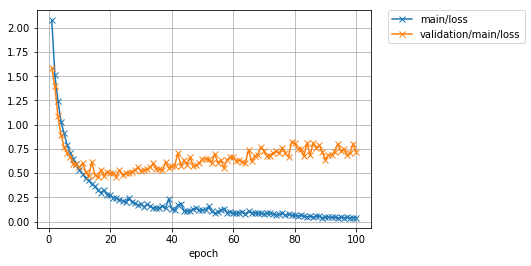

In [39]:
Image(filename='DeepCNN_cifar10_result/loss.png')

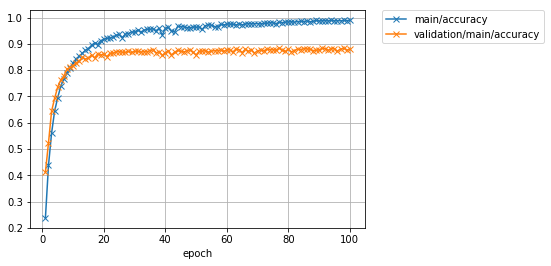

In [40]:
Image(filename='DeepCNN_cifar10_result/accuracy.png')

先程はテストデータでの精度が62&だった。今回は88%くらいになっている！！

最新の研究成果では97%くらいの精度が出ているようなので、もっと改良の余地がある。

- モデルの改良
- 学習データを擬似的に増やす(Data augmentation)
- 複数のモデルの出力を使う(Ensemble)

などである。まだ新しい分野なので、自分の考えた手法が最先端になる可能性がある。
いろいろと試して、世の中の役に立つ手法をつくろう！
